# Modeling and Simulation in Python

Chapter 22

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Vectors

A `Vector` object represents a vector quantity.  In the context of mechanics, vector quantities include position, velocity, acceleration, and force, all of which might be in 2D or 3D.

You can define a `Vector` object without units, but if it represents a physical quantity, you will often want to attach units to it.

I'll start by grabbing the units we'll need.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram

<Unit('kilogram')>

Here's a two dimensional `Vector` in meters.

In [3]:
A = Vector(3, 4) * m

<Quantity([3. 4.], 'meter')>

We can access the elements by name.

In [4]:
A.x

<Quantity(3.0, 'meter')>

In [5]:
A.y

<Quantity(4.0, 'meter')>

The magnitude is the length of the vector.

In [6]:
A.mag

<Quantity(5.0, 'meter')>

The angle is the number of radians between the vector and the positive x axis.

In [7]:
A.angle

<Quantity(0.9272952180016122, 'radian')>

If we make another `Vector` with the same units,

In [8]:
B = Vector(1, 2) * m

<Quantity([1. 2.], 'meter')>

We can add `Vector` objects like this

In [9]:
A + B

<Quantity([4. 6.], 'meter')>

And subtract like this:

In [10]:
A - B

<Quantity([2. 2.], 'meter')>

We can compute the Euclidean distance between two Vectors.

In [11]:
A.dist(B)

<Quantity(2.8284271247461903, 'meter')>

And the difference in angle

In [12]:
A.diff_angle(B)

<Quantity(-0.17985349979247822, 'radian')>

If we are given the magnitude and angle of a vector, what we have is the representation of the vector in polar coordinates.

In [13]:
mag = A.mag
angle = A.angle

<Quantity(0.9272952180016122, 'radian')>

We can use `pol2cart` to convert from polar to Cartesian coordinates, and then use the Cartesian coordinates to make a `Vector` object.

In this example, the `Vector` we get should have the same components as `A`.

In [14]:
x, y = pol2cart(angle, mag)
Vector(x, y)

<Quantity([3. 4.], 'meter')>

Another way to represent the direction of `A` is a unit vector, which is a vector with magnitude 1 that points in the same direction as `A`.  You can compute a unit vector by dividing a vector by its magnitude:

In [15]:
A / A.mag

<Quantity([0.6 0.8], 'dimensionless')>

Or by using the `hat` function, so named because unit vectors are conventionally decorated with a hat, like this: $\hat{A}$:

In [16]:
A.hat()

<Quantity([0.6 0.8], 'dimensionless')>

**Exercise:** Create a `Vector` named `a_grav` that represents acceleration due to gravity, with x component 0 and y component $-9.8$ meters / second$^2$.

In [17]:
# Solution

a_grav = Vector(0, -9.8) * m / s**2

<Quantity([ 0.  -9.8], 'meter / second ** 2')>

### Degrees and radians

Pint provides units to represent degree and radians.

In [18]:
degree = UNITS.degree
radian = UNITS.radian

<Unit('radian')>

If you have an angle in degrees,

In [19]:
angle = 45 * degree
angle

<Quantity(45, 'degree')>

You can convert to radians.

In [20]:
angle_rad = angle.to(radian)

<Quantity(0.7853981633974483, 'radian')>

If it's already in radians, `to` does the right thing.

In [21]:
angle_rad.to(radian)

<Quantity(0.7853981633974483, 'radian')>

You can also convert from radians to degrees.

In [22]:
angle_rad.to(degree)

<Quantity(45.0, 'degree')>

As an alterative, you can use `np.deg2rad`, which works with Pint quantities, but it also works with simple numbers and NumPy arrays:

In [23]:
np.deg2rad(angle)

<Quantity(0.7853981633974483, 'radian')>

**Exercise:** Create a `Vector` named `a_force` that represents acceleration due to a force of 0.5 Newton applied to an object with mass 0.3 kilograms, in a direction 45 degrees up from the positive x-axis.

Add `a_force` to `a_grav` from the previous exercise.  If that addition succeeds, that means that the units are compatible.  Confirm that the total acceleration seems to make sense.

In [24]:
# Solution

N = UNITS.newton
mag = 0.5 * N
angle = 45 * degree
theta = angle.to(radian)
x, y = pol2cart(theta, mag)
force = Vector(x, y)

mass = 0.3 * kg
a_force = force / mass
a_force

<Quantity([1.1785113 1.1785113], 'newton / kilogram')>

In [25]:
# Solution

a_force + a_grav

<Quantity([ 1.1785113 -8.6214887], 'newton / kilogram')>

### Baseball

Here's a `Params` object that contains parameters for the flight of a baseball.

In [53]:
params = Params(x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 145e-3 * kg,
                diameter = 73e-3 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.33,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 5.1 * s)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.33
angle,45 degree
velocity,40.0 meter / second
t_end,5.1 second


And here's the function that uses the `Params` object to make a `System` object.

In [54]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

Here's how we use it:

In [55]:
system = make_system(params)
system

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.33
angle,45 degree
velocity,40.0 meter / second
t_end,5.1 second


Here's a function that computes drag force using vectors:

In [56]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * v.mag**2 * C_d * area / 2
    direction = v.hat()
    f_drag = mag * direction
    return f_drag

Here's the slope function that computes acceleration due to gravity and drag.

In [57]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    v = Vector(vx, vy)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

Always test the slope function with the initial conditions.

In [58]:
slope_func(system.init, 0, system)

(<Quantity(28.284271247461902, 'meter / second')>,
 <Quantity(28.2842712474619, 'meter / second')>,
 <Quantity(-6.466030881564545, 'meter / second ** 2')>,
 <Quantity(-16.266030881564546, 'meter / second ** 2')>)

Now we can call `run_ode_solver`

In [59]:
ts = linspace(0, system.t_end, 101)
results, details = run_ode_solver(system, slope_func, t_eval=ts)
details

,values
sol,None
t_events,[]
nfev,44
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


Here are the results.

In [60]:
results.tail()

,x,y,vx,vy
4.896,97.762912,2.363757,14.397035,-21.342016
4.947,98.494694,1.266539,14.288753,-21.680027
4.998,99.220899,0.152220,14.180404,-22.014039
5.049,99.941500,-0.978993,14.072022,-22.344019
5.100,100.656471,-2.126889,13.963641,-22.669931


The value of `y` at the end is negative, which means the ball has fallen through the ground.  We'll fix that soon, but first let's take a look at the results.

### Visualizing the results

The simplest way to visualize the results is to plot x and y as functions of time.

Saving figure to file figs/chap10-fig01.pdf


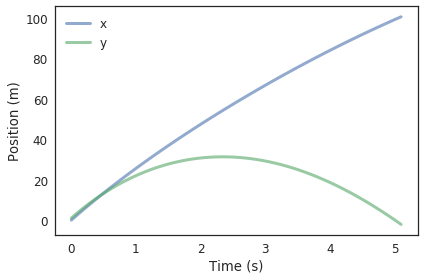

In [61]:
plot(results.x, label='x')
plot(results.y, label='y')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

savefig('figs/chap10-fig01.pdf')

We can plot the velocities the same way.

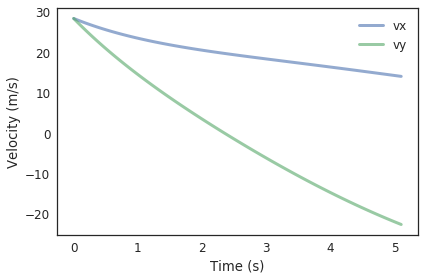

In [62]:
plot(results.vx, label='vx')
plot(results.vy, label='vy')

decorate(xlabel='Time (s)',
         ylabel='Velocity (m/s)')

The x velocity slows down due to drag.

The y velocity drops quickly while drag and gravity are in the same direction, then more slowly after the ball starts to fall.

Another way to visualize the results is to plot y versus x.  The result is the trajectory of the ball through its plane of motion.

Saving figure to file figs/chap10-fig02.pdf


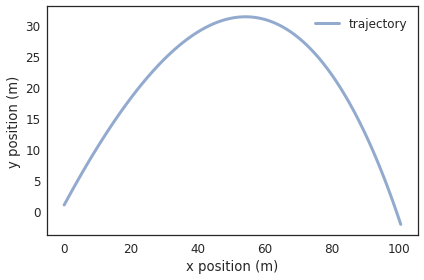

In [63]:
def plot_trajectory(results):
    plot(results.x, results.y, label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)
savefig('figs/chap10-fig02.pdf')

**Exercise:** Run the simulation for a few different launch angles and visualize the results.  Are they consistent with your expectations?

### Range finding

We can use an event function to stop the simulation when the ball hits the ground:

In [64]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

In [65]:
event_func(system.init, 0, system)

<Quantity(1, 'meter')>

In [66]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[5.00490710495864]]
nfev,44
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [67]:
results

,x,y,vx,vy
0.000000,0.000000,1.000000e+00,28.284271,28.284271
0.000061,0.001731,1.001731e+00,28.283875,28.283276
0.000673,0.019044,1.019042e+00,28.279918,28.273320
0.006795,0.192040,1.191814e+00,28.240429,28.173891
0.068010,1.908878,2.886329e+00,27.853762,27.192324
0.680164,17.928830,1.676158e+01,24.674152,18.425060
2.415277,55.711907,3.130573e+01,19.492453,-0.732234
5.004907,99.318821,-3.552714e-15,14.165726,-22.058966


Now the final value of `y` is close to 0.

The final value of `x` tells us the how far the ball landed from home plate:

In [68]:
x_dist = get_last_value(results.x) * m

<Quantity(99.31882093441041, 'meter')>

The final label tells us the flight time.

In [69]:
flight_time = get_last_label(results) * s

<Quantity(5.00490710495864, 'second')>

If we plot the results, we see that the ODE solver was able to take large time steps.

That's good for efficiency, but bad for visualization.

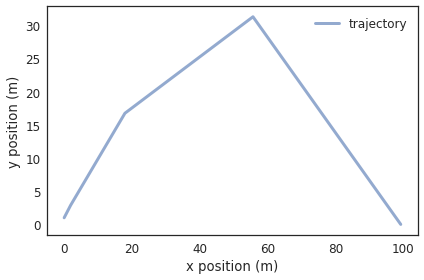

In [70]:
plot_trajectory(results)

We can get a smooth representation of the solution using the `t_eval` option with the flight time we just computed.

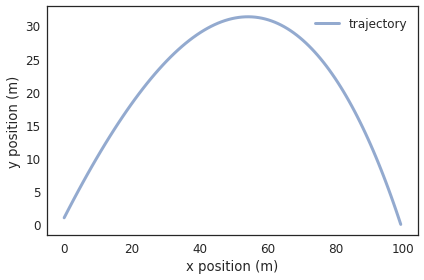

In [71]:
ts = linspace(0, flight_time, 101)
results, details = run_ode_solver(system, slope_func, t_eval=ts)
plot_trajectory(results)

### Exercises

**Exercise:** The baseball stadium in Denver, Colorado is 1,580 meters above sea level, where the density of air is about 1.0 kg / meter$^3$.  How much farther would a ball hit with the same velocity and launch angle travel?

Hint: create a new `Params` object like this:

In [72]:
params2 = Params(params, rho=1*kg/m**3)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.0 kilogram / meter ** 3
C_d,0.33
angle,45 degree
velocity,40.0 meter / second
t_end,5.1 second


In [73]:
# Solution

system2 = make_system(params2)
results2, details2 = run_ode_solver(system2, slope_func, events=event_func)
x_dist = get_last_value(results2.x) * m

<Quantity(105.68279614420348, 'meter')>

**Exercise:** The model so far is based on the assumption that coefficient of drag does not depend on velocity, but in reality it does.  The following figure, from Adair, [*The Physics of Baseball*](https://books.google.com/books/about/The_Physics_of_Baseball.html?id=4xE4Ngpk_2EC), shows coefficient of drag as a function of velocity.

<img src="data/baseball_drag.png" width="400">


I used [an online graph digitizer](https://automeris.io/WebPlotDigitizer/) to extract the data and save it in a CSV file.  Here's how we can read it:

In [74]:
# Solution

baseball_drag = pd.read_csv('data/baseball_drag.csv')
baseball_drag.index = Quantity(baseball_drag['Velocity in mph'].values, UNITS.mph).to(m/s)
baseball_drag

,Velocity in mph,Drag coefficient
0.026146,0.058486,0.49965
8.871509,19.845000,0.49878
17.647351,39.476000,0.49704
22.432914,50.181000,0.48225
26.882303,60.134000,0.45004
30.636992,68.533000,0.40914
32.977694,73.769000,0.38042
34.604472,77.408000,0.36562
37.497268,83.879000,0.34822
40.460249,90.507000,0.33081


Modify the model to include the dependence of `C_d` on velocity, and see how much it affects the results.

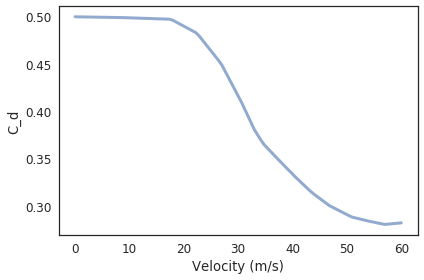

In [75]:
# Solution

drag_interp = interpolate(baseball_drag['Drag coefficient'])
vs = linspace(0, 60, 101)
cds = drag_interp(vs)
plot(vs, cds)
decorate(xlabel='Velocity (m/s)', ylabel='C_d')

In [76]:
# Solution

def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    C_d = drag_interp(v.mag)
    mag = -rho * v.mag**2 * C_d * area / 2
    direction = v.hat()
    f_drag = mag * direction
    return f_drag

In [77]:
# Solution

results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[4.919407063460681]]
nfev,44
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [78]:
# Solution

results

,x,y,vx,vy
0.000000,0.000000,1.000000e+00,28.284271,28.284271
0.000061,0.001731,1.001731e+00,28.283871,28.283271
0.000673,0.019044,1.019042e+00,28.279871,28.273273
0.006795,0.192038,1.191812e+00,28.239920,28.173382
0.068010,1.908629,2.886082e+00,27.845142,27.183821
0.680164,17.841196,1.668401e+01,24.322353,18.129987
2.222077,50.149108,3.015913e+01,18.236042,0.350431
4.919407,90.206647,7.105427e-15,11.640440,-20.837214


In [79]:
# Solution

x_dist = get_last_value(results.x) * m

<Quantity(90.20664656623309, 'meter')>

In [87]:
# Solution

vs = np.hypot(results.vx, results.vy)
interval = min(vs), max(vs)

(18.23940861149146, 40.0)

In [88]:
# Solution

drag_interp(interval),  

(array([0.49521022, 0.33351435]),)